In [37]:
def final_evaluation_table(ticker="AMD"):
    # --- Step 1: Gap% ---
    df = yf.download(ticker, period="60d", interval="1d", auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df[~df.index.weekday.isin([5, 6])]
    df = df[~df.index.duplicated(keep='first')]
    df["PrevClose"] = df["Close"].shift(1)
    df["Gap%"] = ((df["Open"] - df["PrevClose"]) / df["PrevClose"]) * 100

    # --- Step 2 & 3: RSI & 20MA ---
    from ta.momentum import RSIIndicator
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["20MA"] = df["Close"].rolling(20).mean()

    # --- Step 4: Volume ratio ---
    intraday = yf.download(ticker, period="60d", interval="30m", auto_adjust=True)
    if isinstance(intraday.columns, pd.MultiIndex):
        intraday.columns = intraday.columns.get_level_values(0)
    intraday = intraday[~intraday.index.weekday.isin([5, 6])]
    intraday = intraday[~intraday.index.duplicated(keep='first')]
    avg_vol_by_time = intraday.groupby(intraday.index.time)["Volume"].mean()

    volume_ratios = []
    for date in df.index[-30:]:
        day_data = intraday[intraday.index.date == date.date()]
        if day_data.empty:
            volume_ratios.append(None)
        else:
            first_30m_vol = day_data["Volume"].iloc[0]
            avg_vol_30m = avg_vol_by_time.iloc[0]
            volume_ratios.append(first_30m_vol / avg_vol_30m if avg_vol_30m > 0 else None)

    df = df.tail(30).copy()
    df["Volume_ratio_30m"] = volume_ratios

    # --- Final Trade Signal ---
    df["Trade_signal"] = (df["Gap%"] > 2) & (df["RSI"] > 50) & (df["Open"] > df["20MA"])

    return df[["Open", "PrevClose", "Gap%", "RSI", "20MA", "Volume_ratio_30m", "Trade_signal"]]


# --- Run ---
df_final = final_evaluation_table("AMD")
print(df_final)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price             Open   PrevClose      Gap%        RSI        20MA  \
Date                                                                  
2025-06-20  129.000000  126.790001  1.743039  68.787187  118.194500   
2025-06-23  130.470001  128.240005  1.738924  70.149513  119.138000   
2025-06-24  133.429993  129.580002  2.971130  77.220948  120.544000   
2025-06-25  140.940002  138.429993  1.813198  80.075523  121.986000   
2025-06-26  145.970001  143.399994  1.792195  80.225868  123.527000   
2025-06-27  144.179993  143.679993  0.347996  80.300195  125.066000   
2025-06-30  144.000000  143.809998  0.132120  75.792655  126.624499   
2025-07-01  138.770004  141.899994 -2.205772  64.054467  127.698499   
2025-07-02  135.529999  136.110001 -0.426127  66.387893  128.759000   
2025-07-03  139.110001  138.520004  0.425929  65.233596  129.725500   
2025-07-07  136.559998  137.910004 -0.978904  59.548779  130.681000   
2025-07-08  137.320007  134.800003  1.869439  62.927332  131.762500   
2025-0

In [ ]:
import yfinance as yf
import pandas as pd
from ta.momentum import RSIIndicator

def evaluate_with_signal(ticker="AMD"):
    # Download daily data
    df = yf.download(ticker, period="60d", interval="1d", auto_adjust=True)

    # Flatten if columns are multi-index (from yfinance)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Remove duplicate dates
    df = df[~df.index.duplicated(keep='first')]

    # Add indicators
    df["PrevClose"] = df["Close"].shift(1)
    df["Gap%"] = ((df["Open"] - df["PrevClose"]) / df["PrevClose"]) * 100
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["20MA"] = df["Close"].rolling(20).mean()

    # Trade signal: Gap > 2%, RSI > 50, Open > 20MA
    df["Trade_signal"] = (df["Gap%"] > 2) & (df["RSI"] > 50) & (df["Open"] > df["20MA"])

    # Next-day return: from today's open to next day's close
    df["Next_close"] = df["Close"].shift(-1)
    df["Next_day_return%"] = ((df["Next_close"] - df["Open"]) / df["Open"]) * 100

    return df.tail(30)[
        ["Open", "PrevClose", "Gap%", "RSI", "20MA", "Trade_signal", "Next_day_return%"]
    ]

# --- Run ---
df_eval = evaluate_with_signal("AMD")
print(df_eval)


[*********************100%***********************]  1 of 1 completed


KeyError: 'Close'

[*********************100%***********************]  1 of 1 completed


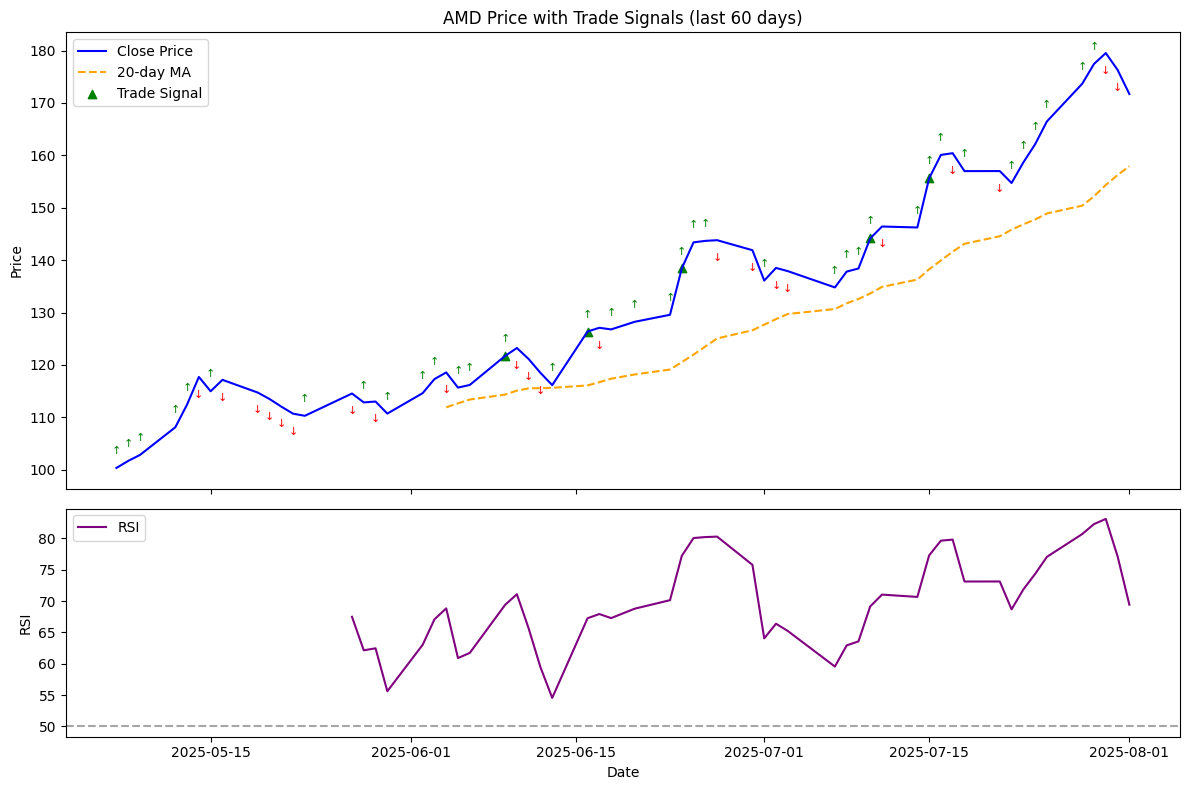

In [43]:
# Run
ticker = "AMD"
df_eval = evaluate_with_signal(ticker)

# Plot with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Price & signals ---
ax1.plot(df_eval.index, df_eval["Close"], label="Close Price", color="blue")
ax1.plot(df_eval.index, df_eval["20MA"], label="20-day MA", linestyle="--", color="orange")

# Mark trade signals
signal_dates = df_eval[df_eval["Trade_signal"]].index
ax1.scatter(signal_dates, df_eval.loc[signal_dates, "Close"], marker="^", color="green", label="Trade Signal")

# Next day return arrows (green if positive, red if negative)
for idx, row in df_eval.iterrows():
    if pd.notna(row["Next_day_return%"]):
        color = "green" if row["Next_day_return%"] > 0 else "red"
        ax1.annotate("↑" if row["Next_day_return%"] > 0 else "↓",
                     xy=(idx, row["Close"]),
                     xytext=(0, 10 if row["Next_day_return%"] > 0 else -15),
                     textcoords="offset points", color=color, ha="center", fontsize=8)

ax1.set_title(f"{ticker} Price with Trade Signals (last 60 days)")
ax1.set_ylabel("Price")
ax1.legend()

# --- RSI ---
ax2.plot(df_eval.index, df_eval["RSI"], label="RSI", color="purple")
ax2.axhline(50, linestyle="--", color="grey", alpha=0.7)
ax2.set_ylabel("RSI")
ax2.set_xlabel("Date")
ax2.legend()

plt.tight_layout()
plt.show()


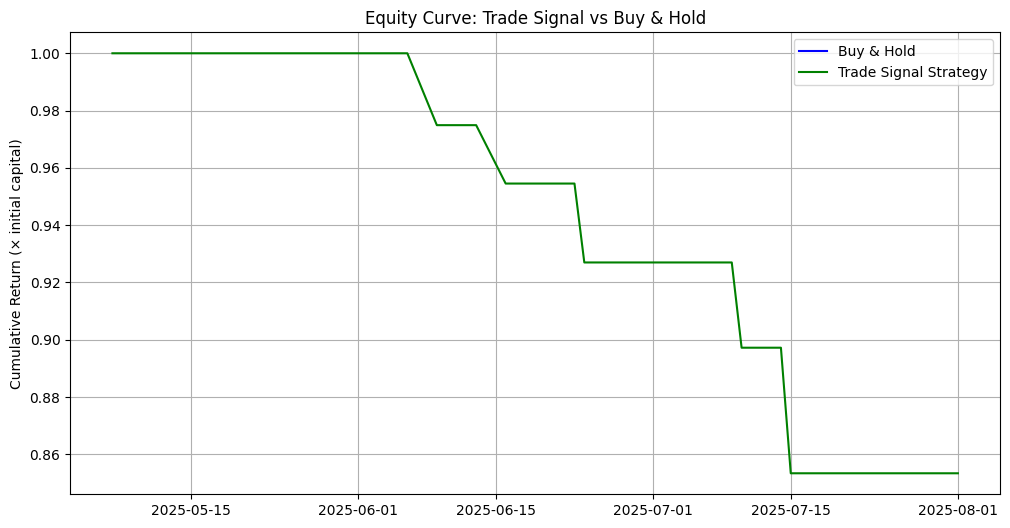

Price       Intraday_return%  Strategy_return%  Cumulative_strategy  \
Date                                                                  
2025-07-21         -0.399689               0.0              0.85341   
2025-07-22          0.512166               0.0              0.85341   
2025-07-23         -1.023545               0.0              0.85341   
2025-07-24         -0.295375               0.0              0.85341   
2025-07-25         -0.850101               0.0              0.85341   
2025-07-28         -1.543648               0.0              0.85341   
2025-07-29         -0.884654               0.0              0.85341   
2025-07-30          1.042083               0.0              0.85341   
2025-07-31         -1.378975               0.0              0.85341   
2025-08-01          3.614242               0.0              0.85341   

Price       Cumulative_buy_hold  
Date                             
2025-07-21                  NaN  
2025-07-22                  NaN  
2025-07-23 

In [ ]:
import matplotlib.pyplot as plt

def backtest_trade_signal(df):
    # Calculate intraday return if you buy at open and sell at close
    df["Intraday_return%"] = ((df["PrevClose"] - df["Open"]) / df["Open"]) * 100

    # Create strategy returns (only trade when signal is True)
    df["Strategy_return%"] = df["Intraday_return%"].where(df["Trade_signal"], 0)

    # Calculate cumulative returns
    df["Cumulative_strategy"] = (1 + df["Strategy_return%"] / 100).cumprod()
    df["Cumulative_buy_hold"] = (df["PrevClose"] / df["PrevClose"].iloc[0])

    # Plot equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Cumulative_buy_hold"], label="Buy & Hold", color="blue")
    plt.plot(df.index, df["Cumulative_strategy"], label="Trade Signal Strategy", color="green")
    plt.title("Equity Curve: Trade Signal vs Buy & Hold")
    plt.ylabel("Cumulative Return (× initial capital)")
    plt.legend()
    plt.grid()
    plt.show()

    return df[["Intraday_return%", "Strategy_return%", "Cumulative_strategy", "Cumulative_buy_hold"]]

# Run backtest
backtest_results = backtest_trade_signal(df_eval)
print(backtest_results.tail(10))


[*********************100%***********************]  1 of 1 completed
C:\Users\Rokas\AppData\Local\Temp\ipykernel_12828\2635945314.py:27: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Next_day_return%"] = df["Close"].shift(-1).pct_change() * 100


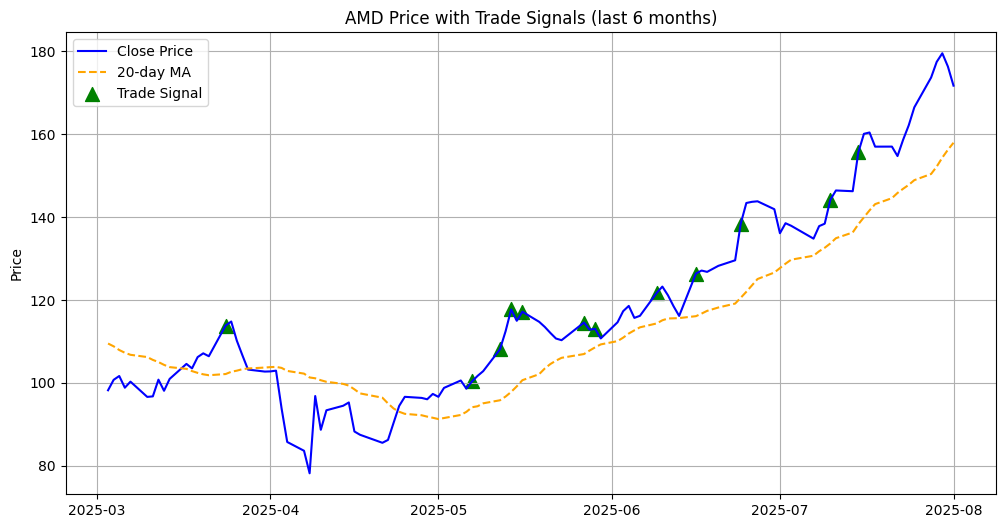

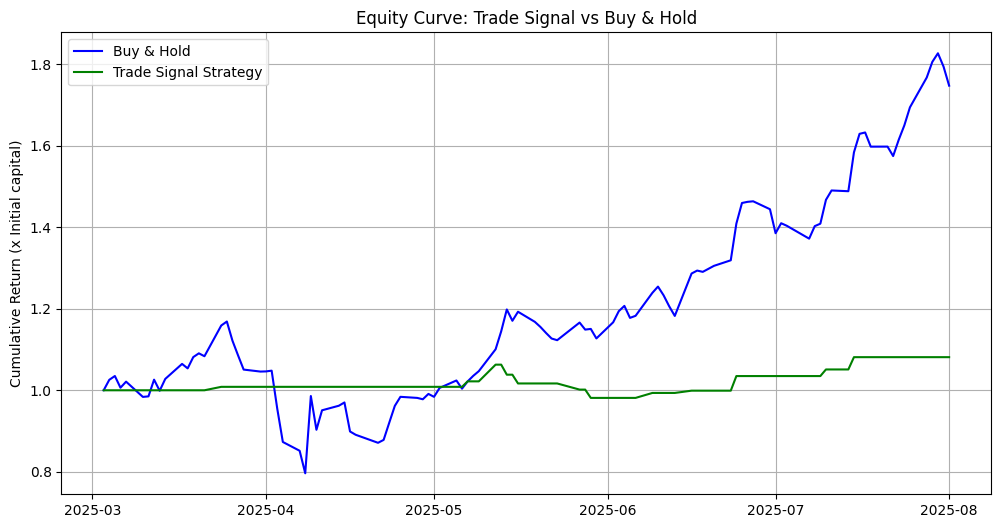

In [46]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator

# Function to evaluate and generate trade signals
def evaluate_with_signal(ticker="AMD"):
    # Download 6 months of daily data
    df = yf.download(ticker, period="6mo", interval="1d", auto_adjust=True)

    # Flatten columns if multi-level (from yfinance)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[~df.index.duplicated(keep='first')]  # Remove duplicates

    # Indicators
    df["PrevClose"] = df["Close"].shift(1)
    df["Gap%"] = ((df["Open"] - df["PrevClose"]) / df["PrevClose"]) * 100
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["20MA"] = df["Close"].rolling(20).mean()

    # Trade signal: Gap% > 2, RSI > 55, Open > 20MA
    df["Trade_signal"] = (df["Gap%"] > 2) & (df["RSI"] > 55) & (df["Open"] > df["20MA"])

    # Next day return
    df["Next_day_return%"] = df["Close"].shift(-1).pct_change() * 100

    return df.dropna()

# --- Run evaluation ---
ticker = "AMD"
df_eval = evaluate_with_signal(ticker)

# --- Plot 1: Price chart with Trade signals ---
plt.figure(figsize=(12, 6))
plt.plot(df_eval.index, df_eval["Close"], label="Close Price", color="blue")
plt.plot(df_eval.index, df_eval["20MA"], label="20-day MA", linestyle="--", color="orange")

# Mark trade signals
trade_days = df_eval[df_eval["Trade_signal"]]
plt.scatter(trade_days.index, trade_days["Close"], label="Trade Signal", marker="^", color="green", s=100)

plt.title(f"{ticker} Price with Trade Signals (last 6 months)")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# --- Plot 2: Equity Curve ---
# Buy & hold return (cumulative)
buy_hold = (1 + df_eval["Close"].pct_change().fillna(0)).cumprod()

# Trade signal strategy return (only next-day returns if trade signal triggered)
strategy_returns = []
capital = 1.0
for idx, row in df_eval.iterrows():
    if row["Trade_signal"]:
        # Apply next day's return if a trade signal is triggered
        next_return = df_eval.loc[idx:, "Close"].pct_change().iloc[1] if len(df_eval.loc[idx:, "Close"]) > 1 else 0
        capital *= (1 + (next_return if pd.notna(next_return) else 0))
    strategy_returns.append(capital)

plt.figure(figsize=(12, 6))
plt.plot(df_eval.index, buy_hold, label="Buy & Hold", color="blue")
plt.plot(df_eval.index, strategy_returns, label="Trade Signal Strategy", color="green")
plt.title("Equity Curve: Trade Signal vs Buy & Hold")
plt.ylabel("Cumulative Return (x Initial capital)")
plt.legend()
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed

Processing AMD...


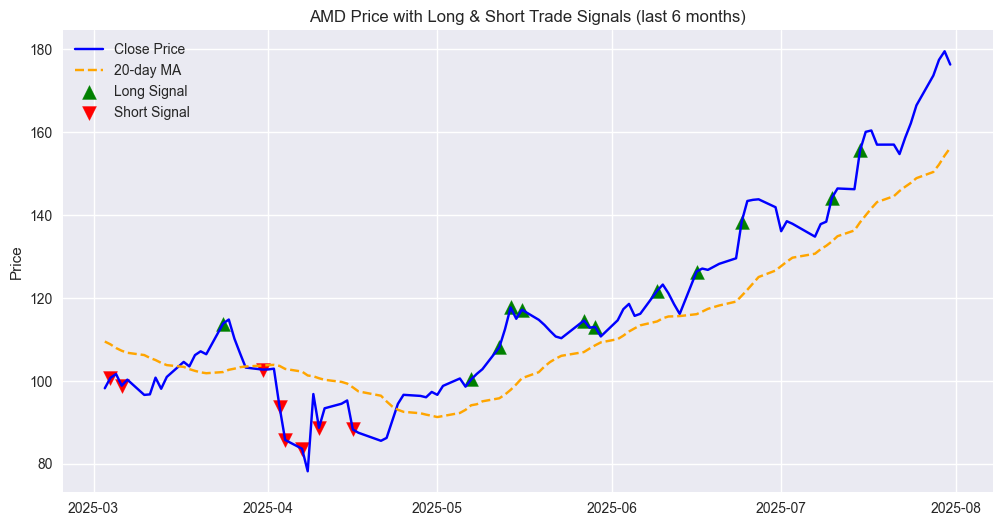

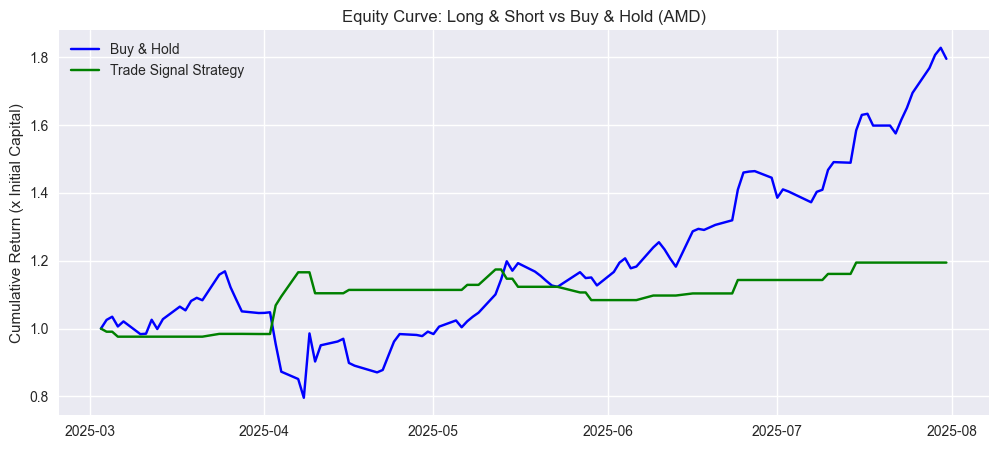

[*********************100%***********************]  1 of 1 completed

Processing NVDA...


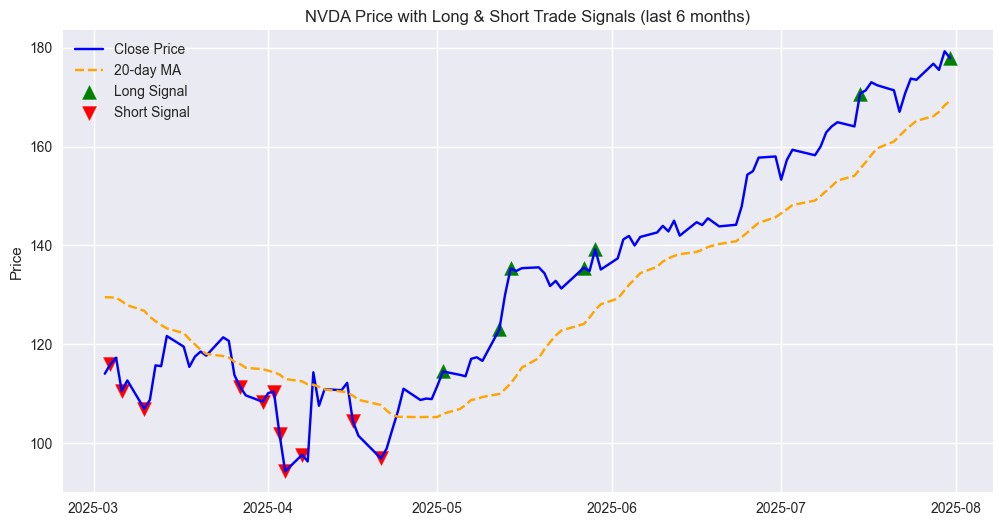

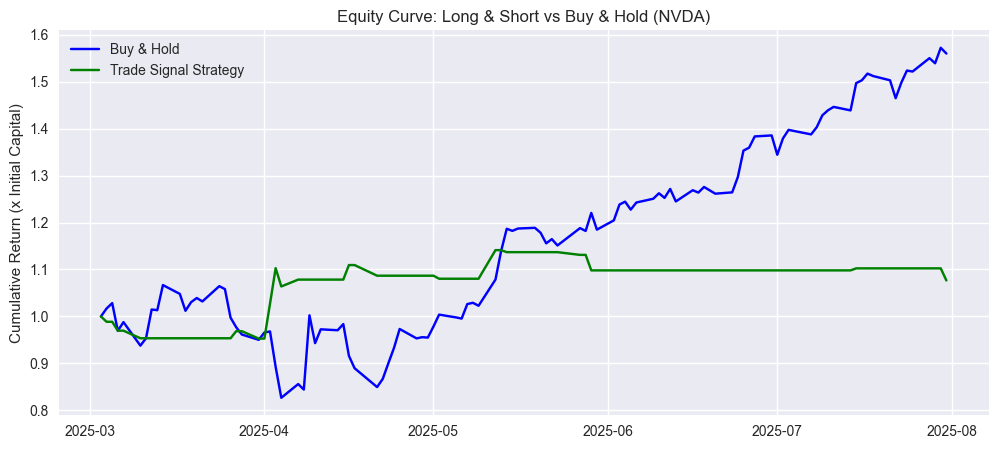

[*********************100%***********************]  1 of 1 completed

Processing MSFT...


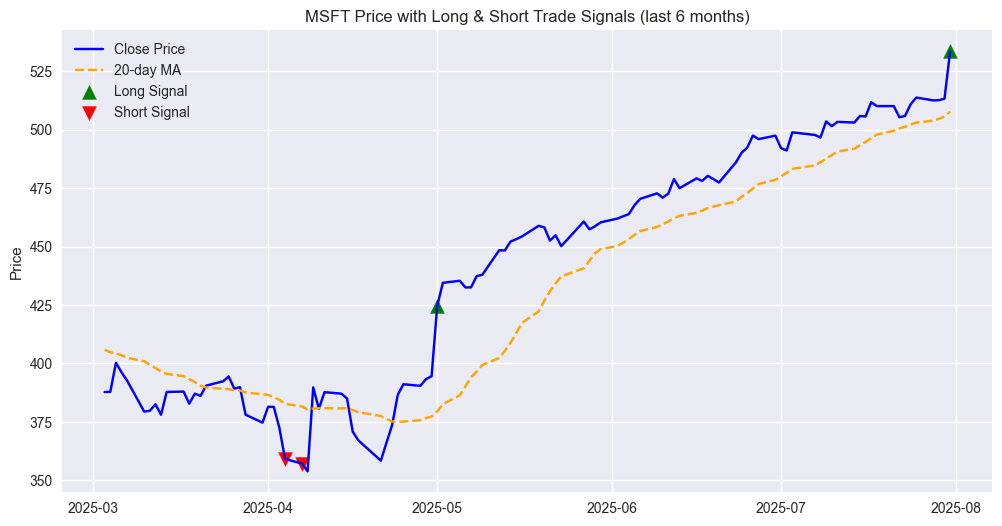

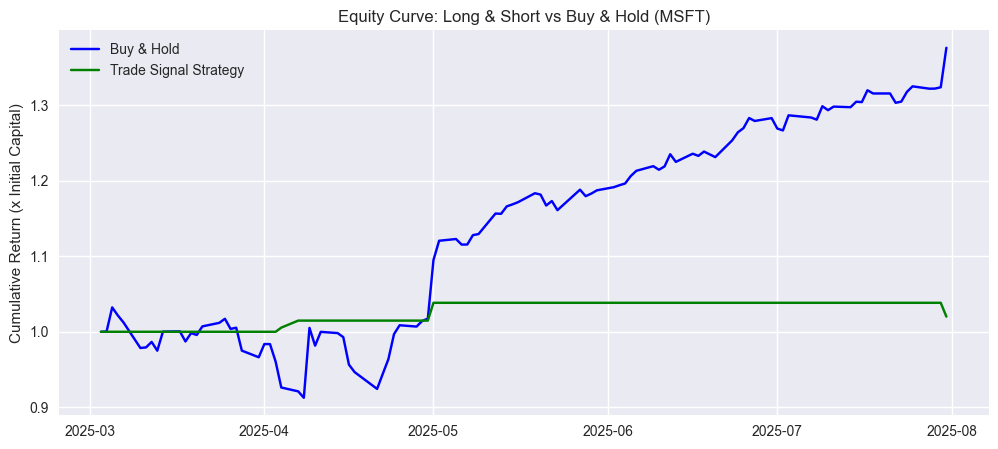

[*********************100%***********************]  1 of 1 completed

Processing AAPL...


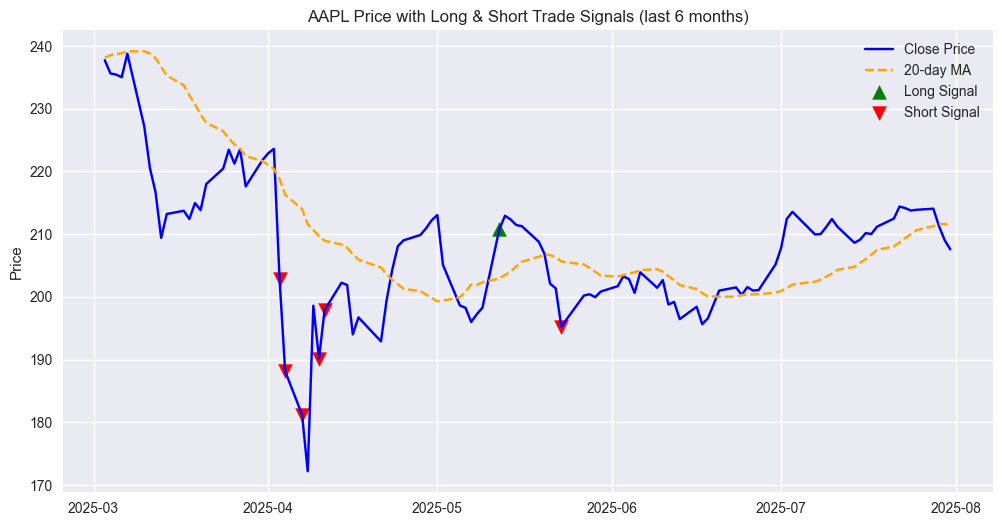

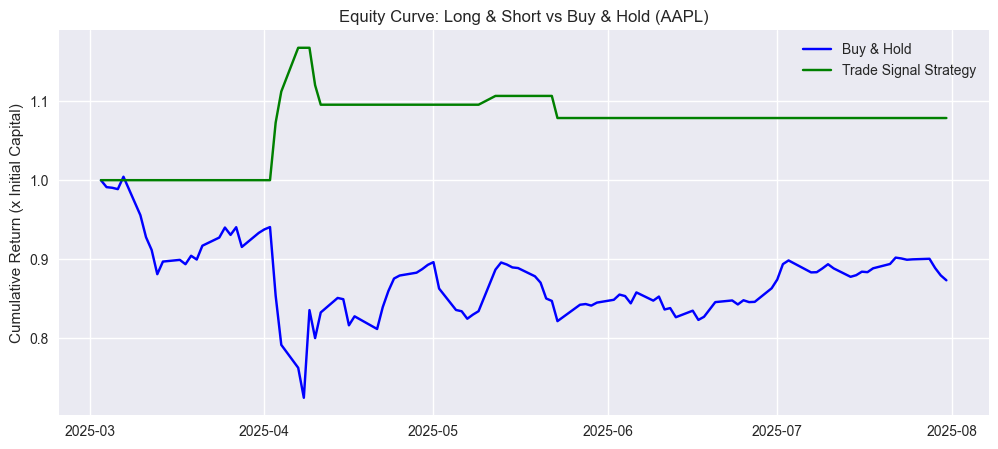

[*********************100%***********************]  1 of 1 completed

Processing TSLA...


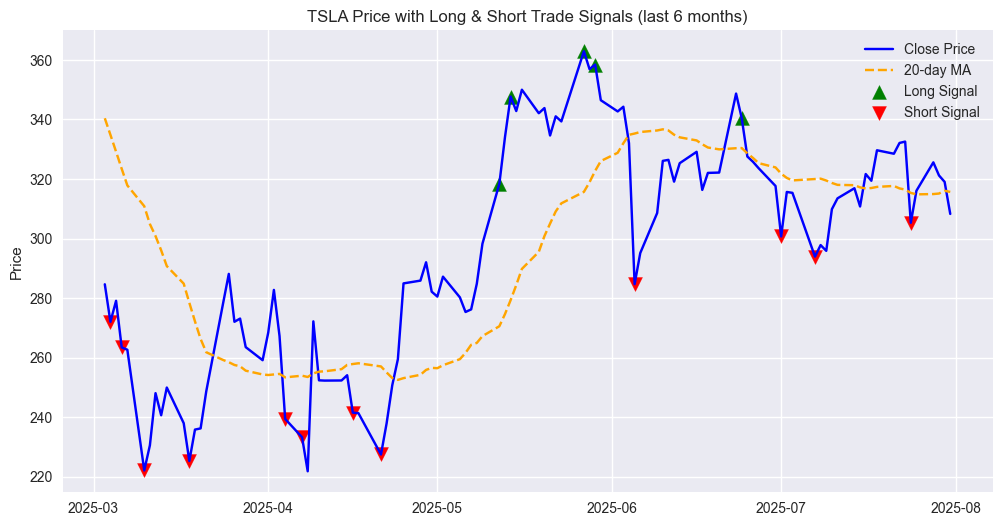

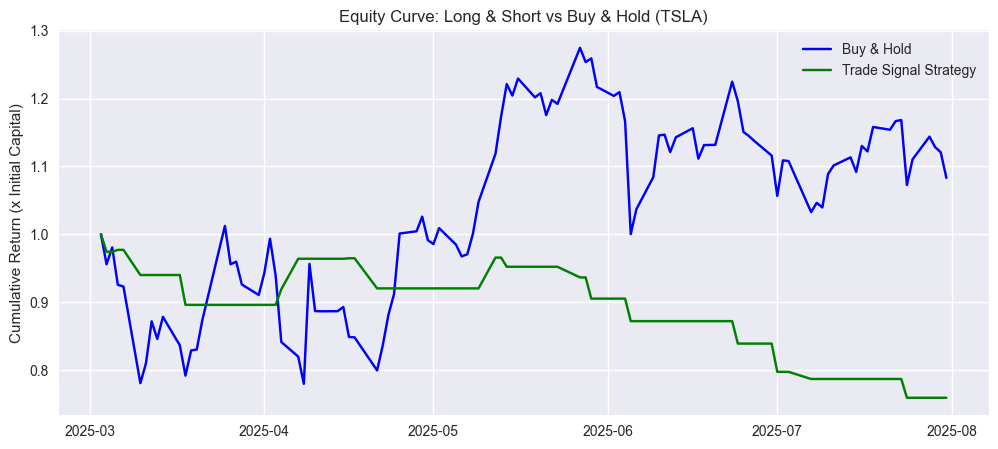

In [48]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator

plt.style.use("seaborn-v0_8")

# --- Evaluation function ---
def evaluate_with_long_short(ticker):
    df = yf.download(ticker, period="6mo", interval="1d", auto_adjust=True)
    if df.empty:
        return None

    # Handle MultiIndex columns from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    df = df[~df.index.duplicated(keep='first')]

    # Indicators
    df["PrevClose"] = df["Close"].shift(1)
    df["Gap%"] = ((df["Open"] - df["PrevClose"]) / df["PrevClose"]) * 100
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["20MA"] = df["Close"].rolling(20).mean()
    df["Next_day_return%"] = df["Close"].pct_change().shift(-1) * 100

    # Signals
    df["Long_signal"] = (df["Gap%"] > 2) & (df["RSI"] > 55) & (df["Close"] > df["20MA"])
    df["Short_signal"] = (df["Gap%"] < -2) & (df["RSI"] < 45) & (df["Close"] < df["20MA"])
    df = df.dropna()

    # Strategy returns
    df["Position"] = 0
    df.loc[df["Long_signal"], "Position"] = 1   # Long
    df.loc[df["Short_signal"], "Position"] = -1 # Short

    df["Strategy_return"] = df["Position"] * (df["Next_day_return%"] / 100)
    df["Equity_curve"] = (1 + df["Strategy_return"]).cumprod()
    df["Buy_hold_curve"] = (1 + df["Close"].pct_change().fillna(0)).cumprod()

    return df

# --- Plotting ---
def plot_results(df, ticker):
    if df is None or df.empty:
        print(f"No data for {ticker}")
        return

    # Plot 1: Price chart
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Close Price", color="blue")
    plt.plot(df.index, df["20MA"], label="20-day MA", linestyle="--", color="orange")

    long_signals = df[df["Long_signal"]]
    short_signals = df[df["Short_signal"]]

    plt.scatter(long_signals.index, long_signals["Close"], marker="^", color="green", label="Long Signal", s=100)
    plt.scatter(short_signals.index, short_signals["Close"], marker="v", color="red", label="Short Signal", s=100)

    plt.title(f"{ticker} Price with Long & Short Trade Signals (last 6 months)")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Plot 2: Equity curve
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df["Buy_hold_curve"], label="Buy & Hold", color="blue")
    plt.plot(df.index, df["Equity_curve"], label="Trade Signal Strategy", color="green")
    plt.title(f"Equity Curve: Long & Short vs Buy & Hold ({ticker})")
    plt.ylabel("Cumulative Return (x Initial Capital)")
    plt.legend()
    plt.show()

# --- Run for multiple tickers ---
tickers = ["AMD", "NVDA", "MSFT", "AAPL", "TSLA"]
results = {}

for ticker in tickers:
    print(f"Processing {ticker}...")
    df_eval = evaluate_with_long_short(ticker)
    results[ticker] = df_eval
    plot_results(df_eval, ticker)


In [50]:
import yfinance as yf
import pandas as pd
from ta.momentum import RSIIndicator

# --- Parameters ---
gap_threshold = 2      # Gap% filter
rsi_threshold = 55     # RSI filter
ma_buffer = 1.05       # Price must be 5% above/below 20MA for longs/shorts

def evaluate_with_summary(ticker, period="6mo"):
    # Download data
    df = yf.download(ticker, period=period, interval="1d", auto_adjust=True)
    if df.empty:
        return None

    # Flatten MultiIndex columns if they exist
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[~df.index.duplicated(keep='first')]

    # Indicators
    df["PrevClose"] = df["Close"].shift(1)
    df["Gap%"] = ((df["Open"] - df["PrevClose"]) / df["PrevClose"]) * 100
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["20MA"] = df["Close"].rolling(20).mean()
    df["Next_day_return%"] = df["Close"].pct_change().shift(-1) * 100

    # Long & Short signals
    df["Long_signal"] = (df["Gap%"] > gap_threshold) & \
                        (df["RSI"] > rsi_threshold) & \
                        (df["Close"] > df["20MA"] * ma_buffer)

    df["Short_signal"] = (df["Gap%"] < -gap_threshold) & \
                         (df["RSI"] < 100 - rsi_threshold) & \
                         (df["Close"] < df["20MA"] / ma_buffer)

    # Trade return simulation
    df["Trade_return%"] = 0.0
    df.loc[df["Long_signal"], "Trade_return%"] = df["Next_day_return%"]
    df.loc[df["Short_signal"], "Trade_return%"] = -df["Next_day_return%"]

    # Cumulative returns
    buy_hold_return = (df["Close"].iloc[-1] / df["Close"].iloc[0]) - 1
    trade_return = (df["Trade_return%"] / 100 + 1).prod() - 1

    trades = df["Long_signal"].sum() + df["Short_signal"].sum()
    wins = ((df["Trade_return%"] > 0) & (df["Long_signal"] | df["Short_signal"])).sum()

    summary = {
        "Ticker": ticker,
        "Buy & Hold Return %": round(buy_hold_return * 100, 2),
        "Trade Signal Return %": round(trade_return * 100, 2),
        "Trades": trades,
        "Win Rate %": round((wins / trades * 100) if trades > 0 else 0, 2)
    }

    return summary


# --- Run on multiple tickers ---
tickers = ["AMD", "NVDA", "MSFT", "AAPL", "TSLA"]
results = []

for ticker in tickers:
    print(f"Processing {ticker}...")
    summary = evaluate_with_summary(ticker)
    if summary:
        results.append(summary)

# Summary table
df_summary = pd.DataFrame(results)
print("\n=== Strategy Summary ===")
print(df_summary.to_string(index=False))


[*********************100%***********************]  1 of 1 completed

Processing AMD...
Processing NVDA...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing MSFT...
Processing AAPL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing TSLA...

=== Strategy Summary ===
Ticker  Buy & Hold Return %  Trade Signal Return %  Trades  Win Rate %
   AMD                50.26                  21.98      18       66.67
  NVDA                48.94                  -4.42      15       26.67
  MSFT                28.04                   2.01       4       75.00
  AAPL               -11.03                   6.79       6       50.00
  TSLA               -21.12                 -18.24      15       33.33
